In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
#to include data_loader
sys.path.append('D:/Deloitte/src/models/')
from data_loader import *
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import joblib

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


In [20]:
#we will load datasets first
data_loader = DataLoader("D:/Deloitte/data/Old data")
additions_on_food = data_loader.load_csv('dim_add_ons.csv') #it contains the price and status and id and category and if it is deleted or not
campaigns_offers = data_loader.load_csv('dim_campaigns.csv') #it contains campaigns (offers) and their places and if it is active or not
stock_items_info = data_loader.load_csv('dim_items.csv')  #it contains items and if there is delivery or takeaway and if it is there and 
#types of additions and if it is displayed for customers
menu_additions = data_loader.load_csv('dim_menu_item_add_ons.csv') #specific add_ons to menu and the price and all are active
menu_items_info = data_loader.load_csv('dim_menu_items.csv') #it contains price and rating and votes and if it is acitve
places_info = data_loader.load_csv("dim_places.csv") #it contains  places and if it is bankrupt and visit_duration and vip threshold
#and waiting_time and binding_period and their title
stock_internal_measuring_units = data_loader.load_csv("dim_skus.csv") #units for measuring stock
stock_categories = data_loader.load_csv("dim_stock_categories.csv") #stock categories ids and titles
taxonomy_terms = data_loader.load_csv("dim_taxonomy_terms.csv") #contains ids that translates into vocab (male,female,bar,cafe,lounge)
users_info = data_loader.load_csv("dim_users.csv") #if account closed,name,country,currency,points,savings,and the role
bonus_codes = data_loader.load_csv("fct_bonus_codes.csv") #bonus ids, points, and duration
campaigns_info = data_loader.load_csv("fct_campaigns.csv") #campaigns titles and items, delivery, what original campaing,the place
#and redemptions and redemptions per_customer and if it is active or not.
#cash_balances = data_loader.load_csv("fct_cash_balances.csv")
#cash_balances.head() #it shows transactions and opening and closing balances
invoice_items = data_loader.load_csv("fct_invoice_items.csv") #it shows specific items with the amount (tablets)
order_items_info = data_loader.load_csv("fct_order_items.csv") #order_tiems and cost, commision, discount, points earned, redeemed,
#quanity, price and status and id of orders and title
orders_info  = data_loader.load_csv("fct_orders.csv") #orders cash amount, cashier, channel, points earned and redeemed, promise_time,
#source and status and total amount and type (takeaway or eat in)
most_ordered = data_loader.load_csv("most_ordered.csv") #most ordered items and count

Successfully loaded dim_add_ons.csv: 9731 rows
Successfully loaded dim_campaigns.csv: 641 rows
Successfully loaded dim_items.csv: 87266 rows
Successfully loaded dim_menu_item_add_ons.csv: 2459 rows
Successfully loaded dim_menu_items.csv: 30407 rows
Successfully loaded dim_places.csv: 1056 rows
Successfully loaded dim_skus.csv: 4 rows
Successfully loaded dim_stock_categories.csv: 3 rows
Successfully loaded dim_taxonomy_terms.csv: 904 rows
Successfully loaded dim_users.csv: 22762 rows
Successfully loaded fct_bonus_codes.csv: 6 rows
Successfully loaded fct_campaigns.csv: 641 rows
Successfully loaded fct_invoice_items.csv: 2918 rows
Successfully loaded fct_order_items.csv: 1974592 rows
Successfully loaded fct_orders.csv: 371667 rows
Successfully loaded most_ordered.csv: 93048 rows


In [21]:
# Add encoding="utf-8" here
with open("list.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(order_items_info['title'].unique()))

In [22]:
import json

def categorize_item(item):
    item_lower = item.lower()
    
    # Logic to assign categories based on keywords
    if any(k in item_lower for k in ["soda", "cola", "vin", "beer", "øl", "juice", "coffee", "kaffe", "tea", "the", "latte", "drink", "water", "vand", "lassi", "shake"]):
        return "Beverages"
    elif any(k in item_lower for k in ["sushi", "maki", "nigiri", "gyoza", "tempura", "sashimi", "edamame", "hosomaki"]):
        return "Sushi & Asian"
    elif any(k in item_lower for k in ["sandwich", "wrap", "burger", "pita", "durum", "rulle"]):
        return "Handhelds"
    elif any(k in item_lower for k in ["pizza", "pasta", "steak", "chicken", "meal", "kylling", "kebab", "curry", "bolognese", "lasagna"]):
        return "Main Courses"
    elif any(k in item_lower for k in ["cake", "kage", "dessert", "mousse", "sweet", "oreo", "cookie", "is", "gelato", "cheesecake"]):
        return "Desserts & Sweets"
    elif any(k in item_lower for k in ["brunch", "breakfast", "morning", "morgen", "egg", "bowl", "yogurt", "pancake"]):
        return "Breakfast & Brunch"
    elif any(k in item_lower for k in ["salat", "salad", "greens", "asparges"]):
        return "Salads & Greens"
    elif any(k in item_lower for k in ["fries", "fritter", "pommes", "snacks", "dip", "oliven", "mandler", "nuggets", "samosa"]):
        return "Sides & Snacks"
    elif any(k in item_lower for k in ["klip", "powerbank", "pose", "lighter", "levering", "personale", "deposit"]):
        return "Misc/Services"
    else:
        return "Other/Uncategorized"

# Read your file and create the mapping
item_mapping = {}

try:
    with open('list.txt', 'r', encoding='utf-8') as f:
        for line in f:
            item = line.strip()
            if item:
                # Map the item (Key) to the category (Value)
                category = categorize_item(item)
                item_mapping[item] = category

    # Save to JSON
    with open('full_menu_mapping.json', 'w', encoding='utf-8') as json_f:
        json.dump(item_mapping, json_f, ensure_ascii=False, indent=4)

    print(f"Success! Processed {len(item_mapping)} unique items into 'full_menu_mapping.json'.")

except FileNotFoundError:
    print("Error: list.txt not found. Please place the script in the same folder as your file.")

Success! Processed 19089 unique items into 'full_menu_mapping.json'.


In [23]:
# STEP 2: ITEM-LEVEL FEATURE ENGINEERING
print("\n" + "="*70)
print("STEP 2: ITEM-LEVEL FEATURE ENGINEERING")
print("="*70)

# Convert timestamp
stock_data = order_items_info.copy()
stock_data['date'] = pd.to_datetime(stock_data['created'], errors='coerce')
stock_data['date_only'] = stock_data['date'].dt.date

# Create time-based features
stock_data['day_of_week'] = stock_data['date'].dt.dayofweek
stock_data['is_weekend'] = stock_data['day_of_week'].isin([5, 6]).astype(int)
stock_data['month'] = stock_data['date'].dt.month
stock_data = stock_data[stock_data['title'].isin(item_mapping.keys())]
stock_data['category'] = stock_data['title'].map(item_mapping)
# Holiday features
holidays_2024 = [
    '2023-01-01', '2023-02-21', '2023-03-30', '2023-04-10', '2023-05-01',
    '2023-06-12', '2023-12-25', '2024-01-01', '2024-02-10', '2024-03-30',
    '2024-05-01', '2024-12-25'
]
holidays_dates = pd.to_datetime(holidays_2024)
stock_data['is_holiday'] = stock_data['date_only'].astype('datetime64[ns]').isin(holidays_dates).astype(int)

# Aggregate by item and date
item_sales = stock_data.groupby(['date_only', 'category']).agg({
    'quantity': 'sum',
    'price': 'mean',
    'day_of_week': 'first',
    'is_weekend': 'first',
    'is_holiday': 'first',
    'month': 'first'
}).reset_index()
#highest ten items for training
categories = stock_data['category'].unique()
item_sales.columns = ['date', 'category_name', 'quantity_sold', 'avg_price', 'day_of_week', 'is_weekend', 'is_holiday', 'month']
item_sales['date'] = pd.to_datetime(item_sales['date'])
item_sales = item_sales.sort_values(['category_name', 'date'])

# FILL DATE GAPS FOR EACH ITEM
print(f"\n✓ FILLING DATE GAPS FOR EACH ITEM...")
min_date = item_sales['date'].min()
max_date = item_sales['date'].max()
date_range = pd.date_range(min_date, max_date, freq='D')

# Create complete date range for each item
complete_dates = []
for category in categories:
    for date in date_range:
        complete_dates.append({'date': date, 'category_name': category})

complete_df = pd.DataFrame(complete_dates)

# Merge with existing sales data
item_sales_filled = complete_df.merge(
    item_sales[['date', 'category_name', 'quantity_sold', 'avg_price']],
    on=['date', 'category_name'],
    how='left'
)
# Fill missing quantities with previous row values
print("start filling")
item_sales_filled['quantity_sold'] = item_sales_filled['quantity_sold'].ffill()
item_sales_filled['quantity_sold'] = item_sales_filled['quantity_sold'].bfill()
print("finish filling")
item_sales_filled['avg_price']=item_sales_filled['avg_price'].mean()
# Recalculate temporal features for all rows
item_sales_filled['day_of_week'] = item_sales_filled['date'].dt.dayofweek
item_sales_filled['is_weekend'] = item_sales_filled['day_of_week'].isin([5, 6]).astype(int)
item_sales_filled['is_holiday'] = item_sales_filled['date'].dt.date.astype('datetime64[ns]').isin(holidays_dates).astype(int)
item_sales_filled['month'] = item_sales_filled['date'].dt.month

# Use filled data
item_sales = item_sales_filled.sort_values(['category_name', 'date']).reset_index(drop=True)

print(f"\n✓ ITEM-LEVEL DATA PREPARED WITH DATE GAPS FILLED")
print(f"   ├─ Items: {item_sales['category_name'].nunique()}")
print(f"   ├─ Total records: {len(item_sales)} (including {len(item_sales[item_sales['quantity_sold']==0])} zero-sale days)")
print(f"   ├─ Date range: {item_sales['date'].min().date()} to {item_sales['date'].max().date()}")
print(f"   ├─ Unique days: {len(date_range)}")
print(f"   └─ Avg daily sales per item: {item_sales[item_sales['quantity_sold']>0]['quantity_sold'].mean():.2f} units")

print(f"\nSample Item Sales Data (with gaps filled):")



STEP 2: ITEM-LEVEL FEATURE ENGINEERING

✓ FILLING DATE GAPS FOR EACH ITEM...
start filling
finish filling

✓ ITEM-LEVEL DATA PREPARED WITH DATE GAPS FILLED
   ├─ Items: 10
   ├─ Total records: 11870 (including 0 zero-sale days)
   ├─ Date range: 2021-02-12 to 2024-05-13
   ├─ Unique days: 1187
   └─ Avg daily sales per item: 227.72 units

Sample Item Sales Data (with gaps filled):



STEP 3: PREPARE DATA FOR PER-ITEM XGBOOST MODELS
Axes(0.125,0.11;0.62x0.77)
[[ 4.          0.          0.          2.         -0.34684872]
 [ 5.          1.          0.          2.         -0.3572497 ]
 [ 6.          1.          0.          2.         -0.35670228]
 ...
 [ 4.          0.          0.          5.          5.18373258]
 [ 5.          1.          0.          5.          4.98556664]
 [ 6.          1.          0.          5.          2.01690957]]
Axes(0.125,0.11;0.496x0.77)
[[ 4.          0.          0.          2.         -0.36513575]
 [ 5.          1.          0.          2.         -0.36546145]
 [ 6.          1.          0.          2.         -0.36546145]
 ...
 [ 4.          0.          0.          5.          5.05808657]
 [ 5.          1.          0.          5.          4.82781703]
 [ 6.          1.          0.          5.          2.71858708]]
Axes(0.125,0.11;0.3968x0.77)
[[4.         0.         0.         2.         9.56194545]
 [5.         1.         0.         2.   

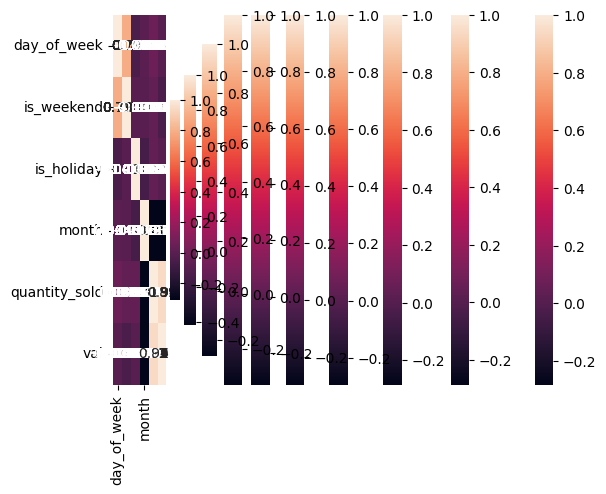

In [24]:
# STEP 3: DATA PREPARATION FOR PER-ITEM MODELING
print("\n" + "="*70)
print("STEP 3: PREPARE DATA FOR PER-ITEM XGBOOST MODELS")
print("="*70)

item_sales_filled = item_sales_filled

# Dictionary to store data for each item
item_data_dict = {}
scaler_price_dict = {}
feature_names = ['day_of_week', 'is_weekend', 'is_holiday', 'month', 'quantity_sold']

for category in categories:
    # Get data for this item only
    item_df = item_sales_filled[item_sales_filled['category_name'] == category].copy()
    
    # Create feature matrix
    X_features = item_df[feature_names].copy()
    
    # Normalize price for this item
    scaler = StandardScaler()
    X_features['quantity'] = scaler.fit_transform(X_features[['quantity_sold']])
    scaler_price_dict[category] = scaler
    X_features.drop('quantity_sold',axis=1,inplace=True)
    # Target: quantity sold (shift by 1 to predict next day)
    y = item_df['quantity_sold'].values[1:]
    X_features = X_features[:-1].values
    df = pd.DataFrame(X_features,columns=['day_of_week', 'is_weekend', 'is_holiday', 'month', 'quantity_sold'])
    df['val']=pd.Series(y)
    #show most correlated items
    print(sns.heatmap(df.corr(),annot=True))
    print(X_features)
    # Train/test split (80/20)
    X_features = X_features[:,3:5]
    train_size = int(len(X_features) * 0.8)
    X_train = X_features[:train_size]
    X_test = X_features[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Store item data
    item_data_dict[category] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'total_samples': len(X_features)
    }

print(f"\n✓ PER-ITEM DATA PREPARED")
print(f"   ├─ Items in models: {len(item_data_dict)}")
print(f"   ├─ Feature Names: {', '.join(feature_names)}")
print(f"   └─ Train/Test Split: 80/20")

print(f"\n📊 DATA SUMMARY BY ITEM:")
for item, data in item_data_dict.items():
    print(f"   {item}:")
    print(f"      ├─ Train samples: {len(data['y_train'])}")
    print(f"      ├─ Test samples: {len(data['y_test'])}")
    print(f"      ├─ Mean sales: {data['y_test'].mean():.2f} units")
    print(f"      └─ Std dev: {data['y_test'].std():.2f} units")

In [26]:
df = pd.DataFrame(X_test,columns=['month','total_qt'])
df['lagged_qt'] = pd.Series(y_test)
df

,month,total_qt,lagged_qt
0,9.0,-0.720177,5.0
1,9.0,-0.788946,5.0
2,9.0,-0.788946,9.0
3,9.0,-0.720177,11.0
4,9.0,-0.685793,15.0
...,...,...,...
233,5.0,2.340044,189.0
234,5.0,2.374429,237.0
235,5.0,3.199657,190.0
236,5.0,2.391621,135.0


In [27]:
df.to_csv("Stock_Forecasting_Test.csv")

In [10]:
# STEP 4: TRAIN PER-ITEM XGBOOST MODELS
print("\n" + "="*70)
print("STEP 4: TRAIN PER-ITEM XGBOOST MODELS")
print("="*70)

# Dictionary to store trained models and metrics
xgb_models_dict = {}
model_metrics = {}

print(f"\n🔄 Training {len(item_data_dict)} models...")

for item, data in item_data_dict.items():
    # Initialize model for this item
    model = xgb.XGBRegressor(
        n_estimators=10000,
        learning_rate=0.005,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        verbose=0
    )
    
    # Train model
    model.fit(data['X_train'], data['y_train'], verbose=False)
    xgb_models_dict[item] = model
    
    # Predictions
    y_pred_train = model.predict(data['X_train'])
    y_pred_test = model.predict(data['X_test'])
    
    # Evaluation metrics
    train_r2 = r2_score(data['y_train'], y_pred_train)
    test_r2 = r2_score(data['y_test'], y_pred_test)
    rmse = np.sqrt(mean_squared_error(data['y_test'], y_pred_test))
    mae = mean_absolute_error(data['y_test'], y_pred_test)
    mape = np.mean(np.abs((data['y_test'] - y_pred_test) / (data['y_test'] + 1))) * 100
    
    model_metrics[item] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'importances': model.feature_importances_
    }

print("✓ All models trained successfully!")

print(f"\n" + "="*70)
print("PER-ITEM MODEL PERFORMANCE SUMMARY")
print("="*70)

for category in sorted(model_metrics.keys()):
    metrics = model_metrics[category]
    print(f"\n{item}:")
    print(f"   ├─ Train R²: {metrics['train_r2']:.4f}")
    print(f"   ├─ Test R²: {metrics['test_r2']:.4f}")
    print(f"   ├─ RMSE: {metrics['rmse']:.2f} units")
    print(f"   ├─ MAE: {metrics['mae']:.2f} units")
    print(f"   └─ MAPE: {metrics['mape']:.2f}%")

# Feature importance across all models
print(f"\n" + "="*70)
print("FEATURE IMPORTANCE BY ITEM")
print("="*70)

for item in sorted(model_metrics.keys()):
    importances = model_metrics[item]['importances']
    print(f"\n{item}:")
    for fname, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"   {fname}: {imp:.4f}")


STEP 4: TRAIN PER-ITEM XGBOOST MODELS

🔄 Training 10 models...
✓ All models trained successfully!

PER-ITEM MODEL PERFORMANCE SUMMARY

Misc/Services:
   ├─ Train R²: 0.8870
   ├─ Test R²: -0.9425
   ├─ RMSE: 4235.05 units
   ├─ MAE: 2952.37 units
   └─ MAPE: 73.71%

Misc/Services:
   ├─ Train R²: 0.8181
   ├─ Test R²: -0.0606
   ├─ RMSE: 88.34 units
   ├─ MAE: 48.09 units
   └─ MAPE: 58.96%

Misc/Services:
   ├─ Train R²: 0.7289
   ├─ Test R²: -1.1350
   ├─ RMSE: 608.86 units
   ├─ MAE: 444.91 units
   └─ MAPE: 72.64%

Misc/Services:
   ├─ Train R²: 0.7936
   ├─ Test R²: -0.8729
   ├─ RMSE: 804.02 units
   ├─ MAE: 586.93 units
   └─ MAPE: 80.92%

Misc/Services:
   ├─ Train R²: 0.9084
   ├─ Test R²: -0.7545
   ├─ RMSE: 471.54 units
   ├─ MAE: 344.94 units
   └─ MAPE: 68.98%

Misc/Services:
   ├─ Train R²: 0.9918
   ├─ Test R²: 0.1811
   ├─ RMSE: 79.06 units
   ├─ MAE: 54.79 units
   └─ MAPE: 52.56%

Misc/Services:
   ├─ Train R²: 0.9162
   ├─ Test R²: -0.9848
   ├─ RMSE: 7002.88 units


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime

def predict_next_day(current_date, category_name, verbose=True):
    """
    Predict sales volume for the next day for a specific item
    Uses the item-specific trained XGBoost model.
    """
    # 1. Validate item exists in trained models
    if category_name not in xgb_models_dict:
        return {'error': f'Item {category_name} not in trained models.'}

    # 2. Convert to datetime if string
    current_dt = pd.to_datetime(current_date)
    next_dt = current_dt + pd.Timedelta(days=1)

    # 3. Extract time-based features for the prediction date (Next Day)
    day_of_week = next_dt.dayofweek
    is_weekend = 1 if next_dt.dayofweek in [5, 6] else 0
    # Assumes holidays_dates is a list of datetime objects available in scope
    is_holiday = 1 if next_dt.date() in [d.date() for d in holidays_dates] else 0
    month = next_dt.month

    # 4. Get the feature: "Quantity Sold" from the current_date (Today)
    # We filter for the specific item
    item_data = item_sales_filled[item_sales_filled['category_name'] == category_name]
    
    if item_data.empty:
        return {'error': f'No historical data for item {category_name}'}

    # Find the row corresponding to "today" to use its quantity as a feature for "tomorrow"
    selected_row = item_data[item_data['date'] == current_dt]

    if not selected_row.empty:
        last_qty = float(selected_row['quantity_sold'].iloc[0])
    else:
        # Fallback: Find the most recent date available BEFORE or ON the current_dt
        recent_data = item_data[item_data['date'] <= current_dt].sort_values('date')
        if not recent_data.empty:
            last_qty = float(recent_data['quantity_sold'].iloc[-1])
        else:
            last_qty = 0.0

    # 5. Scale the quantity feature
    scaler = scaler_price_dict.get(category_name)
    if scaler is not None:
        # Reshape for scaler: [[value]]
        qty_scaled = float(scaler.transform([[last_qty]])[0][0])
    else:
        qty_scaled = last_qty

    # 6. Create feature vector (Must match training order exactly)
    features = np.array([[
        month,
        qty_scaled
    ]])

    # 7. Get model and performance metrics
    model = xgb_models_dict[category_name]
    metrics = model_metrics.get(category_name, {})
    mae = metrics.get('mae', 0)
    r2 = metrics.get('test_r2', 0)

    # 8. Make prediction
    # XGBoost returns an array, we take the first element
    prediction = float(model.predict(features)[0])
    
    # Ensure we don't predict negative sales
    prediction = max(0, prediction)

    # 9. Calculate Bounds and Safety Stock
    lower_bound = max(0, prediction - mae)
    upper_bound = prediction + mae
    safety_stock = prediction + mae # Simple recommendation: Predict + Error Margin

    if verbose:
        print(f"\n📅 WALKFORWARD PREDICTION ({category_name})")
        print(f"   Current Date: {current_dt.date()} (Qty: {last_qty})")
        print(f"   Predict For: {next_dt.date()}")
        print(f"\n📊 FEATURES:")
        print(f"   ├─ Day: {next_dt.day_name()} | Month: {next_dt.month}")
        print(f"   └─ Holiday: {'Yes' if is_holiday else 'No'}")
        print(f"\n🎯 PREDICTION:")
        print(f"   ├─ Expected Sales: {prediction:.2f} units")
        print(f"   ├─ Confidence Range: [{lower_bound:.2f} - {upper_bound:.2f}]")
        print(f"   └─ Model Accuracy (R²): {r2:.4f}")

    return {
        'date': next_dt.date(),
        'category_name': category_name,
        'predicted_quantity': prediction,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'safety_stock': safety_stock,
        'model_r2': r2,
        'confidence_margin': (upper_bound - lower_bound),
        'feature_used': last_qty
    }

In [12]:
# STEP 9: DEMONSTRATION - WALKFORWARD PREDICTIONS WITH PER-ITEM MODELS
print("\n" + "="*70)
print("STEP 9: WALKFORWARD PREDICTIONS FOR TOP 5 ITEMS (PER-ITEM MODELS)")
print("="*70)

# Get the latest date in data
latest_date = item_sales_filled['date'].max()

# Make predictions for top 5 items using their specific models
results_list = []
for category in categories[:5]:
    result = predict_next_day(latest_date,category)
    results_list.append(result)
print(results_list)
# Create results dataframe
results_df = pd.DataFrame([
    {
        'Category': r['category_name'],
        'Predicted Date': r['date'],
        'Predicted Quantity': round(r['predicted_quantity'], 0),
        'Lower Bound': round(r['lower_bound'], 0),
        'Upper Bound': round(r['upper_bound'], 0),
        'Safety Stock': round(r['safety_stock'], 0),
        'Confidence (±)': round(r['confidence_margin'], 0),
        'Model R²': round(r['model_r2'], 4)
    }
    for r in results_list
])
results_df.head(10)


STEP 9: WALKFORWARD PREDICTIONS FOR TOP 5 ITEMS (PER-ITEM MODELS)

📅 WALKFORWARD PREDICTION (Beverages)
   Current Date: 2024-05-13 (Qty: 764.0)
   Predict For: 2024-05-14

📊 FEATURES:
   ├─ Day: Tuesday | Month: 5
   └─ Holiday: No

🎯 PREDICTION:
   ├─ Expected Sales: 135.87 units
   ├─ Confidence Range: [0.00 - 3088.24]
   └─ Model Accuracy (R²): -0.9425

📅 WALKFORWARD PREDICTION (Other/Uncategorized)
   Current Date: 2024-05-13 (Qty: 1466.0)
   Predict For: 2024-05-14

📊 FEATURES:
   ├─ Day: Tuesday | Month: 5
   └─ Holiday: No

🎯 PREDICTION:
   ├─ Expected Sales: 411.71 units
   ├─ Confidence Range: [0.00 - 5376.98]
   └─ Model Accuracy (R²): -0.9848

📅 WALKFORWARD PREDICTION (Sides & Snacks)
   Current Date: 2024-05-13 (Qty: 4.0)
   Predict For: 2024-05-14

📊 FEATURES:
   ├─ Day: Tuesday | Month: 5
   └─ Holiday: No

🎯 PREDICTION:
   ├─ Expected Sales: 4.44 units
   ├─ Confidence Range: [0.00 - 220.90]
   └─ Model Accuracy (R²): -1.2211

📅 WALKFORWARD PREDICTION (Desserts & Sweet

,Category,Predicted Date,Predicted Quantity,Lower Bound,Upper Bound,Safety Stock,Confidence (±),Model R²
0,Beverages,2024-05-14,136.0,0,3088.0,3088.0,3088.0,-0.9425
1,Other/Uncategorized,2024-05-14,412.0,0,5377.0,5377.0,5377.0,-0.9848
2,Sides & Snacks,2024-05-14,4.0,0,221.0,221.0,221.0,-1.2211
3,Desserts & Sweets,2024-05-14,36.0,0,481.0,481.0,481.0,-1.1350
4,Handhelds,2024-05-14,15.0,0,602.0,602.0,602.0,-0.8729


In [13]:
# STEP 5: PREPARE SEQUENCES FOR LSTM MODELS
print("\n" + "="*70)
print("STEP 5: PREPARE SEQUENCES FOR LSTM MODELS")
print("="*70)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_sequences(data, lookback=10):
    """
    Create sequences for LSTM training.
    Parameters:
    -----------
    data : array
        Input data (features only)
    lookback : int
        Number of previous timesteps to use as input
    Returns:
    --------
    X : array of shape (n_sequences, lookback, n_features)
    """
    X = []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
    return np.array(X)

# Dictionary to store LSTM sequence data
lstm_sequence_dict = {}
lookback_window = 10  # Use 10 days of history to predict next day

print(f"\n🔄 Creating sequences (lookback window: {lookback_window} days)...")

for category in categories:
    # Get data for this item
    item_df = item_sales_filled[item_sales_filled['category_name'] == category].copy()
    
    # Create feature matrix (use the same 5 features as XGBoost after scaling)
    features_for_lstm = ['month']
    X_lstm = item_df[features_for_lstm].copy().values
    
    # Add the scaled quantity as 5th feature
    qty_scaled_list = []
    scaler_temp = scaler_price_dict[item]
    for qty in item_df['quantity_sold'].values:
        qty_scaled = float(scaler_temp.transform([[qty]])[0][0])
        qty_scaled_list.append(qty_scaled)
    
    X_lstm = np.column_stack([X_lstm, qty_scaled_list])
    y = item_df['quantity_sold'].values
    
    # Create sequences
    X_seq = create_sequences(X_lstm, lookback=lookback_window)
    y_seq = y[lookback_window:]  # Skip first lookback_window values
    
    # Train/test split (80/20)
    split_idx = int(len(X_seq) * 0.8)
    X_train_seq = X_seq[:split_idx]
    X_test_seq = X_seq[split_idx:]
    y_train_seq = y_seq[:split_idx]
    y_test_seq = y_seq[split_idx:]
    
    # Store sequence data
    lstm_sequence_dict[category] = {
        'X_train_seq': X_train_seq,
        'X_test_seq': X_test_seq,
        'y_train_seq': y_train_seq,
        'y_test_seq': y_test_seq,
        'n_features': X_lstm.shape[1],
        'n_sequences': len(X_seq)
    }

print(lstm_sequence_dict)

print(f"\n📊 SEQUENCE SUMMARY BY ITEM:")
for category in categories[:3]:
    data = lstm_sequence_dict[category]
    print(f"   {category}:")
    print(f"      ├─ Train sequences: {len(data['X_train_seq'])}")
    print(f"      ├─ Test sequences: {len(data['X_test_seq'])}")
    print(f"      ├─ Sequence shape: ({lookback_window}, {data['n_features']})")
    print(f"      └─ Total sequences: {data['n_sequences']}")



STEP 5: PREPARE SEQUENCES FOR LSTM MODELS

🔄 Creating sequences (lookback window: 10 days)...
{'Beverages': {'X_train_seq': array([[[ 2.        ,  0.11960078],
        [ 2.        , -0.5483924 ],
        [ 2.        , -0.51323487],
        ...,
        [ 2.        , -0.1616595 ],
        [ 2.        , -0.44291979],
        [ 2.        , -0.51323487]],

       [[ 2.        , -0.5483924 ],
        [ 2.        , -0.51323487],
        [ 2.        , -0.51323487],
        ...,
        [ 2.        , -0.44291979],
        [ 2.        , -0.51323487],
        [ 2.        , -0.5483924 ]],

       [[ 2.        , -0.51323487],
        [ 2.        , -0.51323487],
        [ 2.        , -0.51323487],
        ...,
        [ 2.        , -0.51323487],
        [ 2.        , -0.5483924 ],
        [ 2.        , -0.5483924 ]],

       ...,

       [[ 9.        ,  2.29936802],
        [ 9.        ,  2.61578585],
        [ 9.        ,  1.94779266],
        ...,
        [ 9.        ,  3.77598454],
        [ 9.

In [14]:
# STEP 6: BUILD AND TRAIN PER-ITEM LSTM MODELS
print("\n" + "="*70)
print("STEP 6: BUILD AND TRAIN PER-ITEM LSTM MODELS (ENHANCED)")
print("="*70)

# Dictionary to store trained LSTM models and metrics
lstm_models_dict = {}
lstm_metrics = {}

print(f"\n🔄 Building and training {len(lstm_sequence_dict)} LSTM models...")
print(f"   Model Architecture:")
print(f"   ├─ LSTM 256 + BatchNorm + Dropout(0.15)")
print(f"   ├─ LSTM 128 + BatchNorm + Dropout(0.15)")
print(f"   ├─ LSTM 64 + BatchNorm + Dropout(0.2)")
print(f"   ├─ Dense 64 + Dropout(0.2)")
print(f"   ├─ Dense 32")
print(f"   └─ Output: Dense 1")
print(f"   Regularization: L1=1e-5, L2=1e-4")
print(f"   Optimizer: Adam(lr=0.0002, clipnorm=1.0)")

for category in categories:
    data = lstm_sequence_dict[category]
    
    # Build LSTM model with exact user-provided architecture
    model = Sequential([
        LSTM(256, activation='relu', return_sequences=True,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             input_shape=(lookback_window, data['n_features'])),
        BatchNormalization(),
        Dropout(0.15),
        
        LSTM(128, activation='relu', return_sequences=True,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.15),
        
        LSTM(64, activation='relu', return_sequences=False,
             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
             recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dense(1)
    ])
    
    # Compile with optimized settings
    model.compile(
        optimizer=Adam(learning_rate=0.0002, clipnorm=1.0),
        loss='mse',  # MSE for better precision on predictions
        metrics=['mae']
    )
    
    print(f"\n   Training {category}...", end='')
    
    # Enhanced callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,            # Increased patience to allow more learning
        restore_best_weights=True,
        min_delta=0.0001        # Minimum improvement threshold
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,             # Reduce LR by 50% when plateau detected
        patience=5,
        min_lr=1e-7,
        verbose=0
    )
    
    # Train model
    history = model.fit(
        data['X_train_seq'], data['y_train_seq'],
        validation_split=0.2,
        epochs=150,             # More epochs with early stopping
        batch_size=16,          # Smaller batch size for better gradient updates
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    print(" ✓")
    
    # Store model
    lstm_models_dict[category] = model
    
    # Predictions
    y_pred_train = model.predict(data['X_train_seq'], verbose=0).flatten()
    y_pred_test = model.predict(data['X_test_seq'], verbose=0).flatten()
    
    # Evaluation metrics
    train_r2 = r2_score(data['y_train_seq'], y_pred_train)
    test_r2 = r2_score(data['y_test_seq'], y_pred_test)
    rmse = np.sqrt(mean_squared_error(data['y_test_seq'], y_pred_test))
    mae = mean_absolute_error(data['y_test_seq'], y_pred_test)
    mape = np.mean(np.abs((data['y_test_seq'] - y_pred_test) / (data['y_test_seq'] + 1))) * 100
    
    lstm_metrics[category] = {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'history': history
    }

print("\n✓ All LSTM models trained successfully!")

print(f"\n" + "="*70)
print("PER-ITEM LSTM MODEL PERFORMANCE SUMMARY")
print("="*70)

for item in sorted(lstm_metrics.keys()):
    metrics = lstm_metrics[item]
    print(f"\n{item}:")
    print(f"   ├─ Train R²: {metrics['train_r2']:.4f}")
    print(f"   ├─ Test R²: {metrics['test_r2']:.4f}")
    print(f"   ├─ RMSE: {metrics['rmse']:.2f} units")
    print(f"   ├─ MAE: {metrics['mae']:.2f} units")
    print(f"   └─ MAPE: {metrics['mape']:.2f}%")



STEP 6: BUILD AND TRAIN PER-ITEM LSTM MODELS (ENHANCED)

🔄 Building and training 10 LSTM models...
   Model Architecture:
   ├─ LSTM 256 + BatchNorm + Dropout(0.15)
   ├─ LSTM 128 + BatchNorm + Dropout(0.15)
   ├─ LSTM 64 + BatchNorm + Dropout(0.2)
   ├─ Dense 64 + Dropout(0.2)
   ├─ Dense 32
   └─ Output: Dense 1
   Regularization: L1=1e-5, L2=1e-4
   Optimizer: Adam(lr=0.0002, clipnorm=1.0)

   Training Beverages... ✓

   Training Other/Uncategorized... ✓

   Training Sides & Snacks... ✓

   Training Desserts & Sweets... ✓

   Training Handhelds... ✓

   Training Main Courses... ✓

   Training Salads & Greens... ✓

   Training Breakfast & Brunch... ✓

   Training Sushi & Asian... ✓

   Training Misc/Services... ✓

✓ All LSTM models trained successfully!

PER-ITEM LSTM MODEL PERFORMANCE SUMMARY

Beverages:
   ├─ Train R²: 0.8379
   ├─ Test R²: 0.0325
   ├─ RMSE: 2989.43 units
   ├─ MAE: 1973.67 units
   └─ MAPE: 52.15%

Breakfast & Brunch:
   ├─ Train R²: 0.7472
   ├─ Test R²: 0.0480

In [15]:
# STEP 7: LSTM WALKFORWARD PREDICTION FUNCTION
print("\n" + "="*70)
print("STEP 7: LSTM WALKFORWARD PREDICTION FUNCTION")
print("="*70)

def predict_next_day_lstm(current_date, category_name, verbose=True):
    """
    Predict sales volume for the next day using LSTM model for a specific item.
    Uses the trained per-item LSTM model and historical data.
    """
    # Validate item
    if category_name not in lstm_models_dict:
        return {'error': f'Item {category_name} not in trained LSTM models. Available: {list(lstm_models_dict.keys())}'}
    
    # Convert to datetime if string
    current_dt = pd.to_datetime(current_date)
    next_dt = current_dt + pd.Timedelta(days=1)
    
    # Extract temporal features for next day
    day_of_week = next_dt.dayofweek
    is_weekend = 1 if next_dt.dayofweek in [5, 6] else 0
    is_holiday = 1 if next_dt.date() in [d.date() for d in holidays_dates] else 0
    month = next_dt.month
    
    # Get item data and last quantity sold
    item_data = item_sales_filled[item_sales_filled['category_name'] == category_name]
    if item_data.empty:
        return {'error': f'No historical data for item {category_name}'}
    
    # Get recent quantity (last non-null or average of last 7 days)
    recent_qty_series = item_data['quantity_sold'].dropna()
    if len(recent_qty_series) == 0:
        last_qty = 0.0
    else:
        last_qty = float(recent_qty_series.iloc[-1]) if not np.isnan(recent_qty_series.iloc[-1]) else float(recent_qty_series.tail(7).mean())
    
    # Scale the quantity using item-specific scaler
    scaler = scaler_price_dict.get(category_name)
    if scaler is None:
        qty_scaled = last_qty
    else:
        qty_scaled = float(scaler.transform([[last_qty]])[0][0])
    
    # Get last lookback_window days for LSTM sequence
    features_for_lstm = ['month']
    historical_data = item_data.tail(lookback_window + 1)[features_for_lstm].values
    
    # Add scaled quantities to features
    hist_qty_values = item_data.tail(lookback_window + 1)['quantity_sold'].values
    hist_qty_scaled = [float(scaler.transform([[q]])[0][0]) for q in hist_qty_values]
    
    sequence_data = np.column_stack([historical_data, hist_qty_scaled])
    
    # Ensure we have exactly lookback_window timesteps
    if len(sequence_data) < lookback_window:
        # Pad with first row if not enough data
        padding = np.tile(sequence_data[0], (lookback_window - len(sequence_data), 1))
        sequence_data = np.vstack([padding, sequence_data])
    else:
        sequence_data = sequence_data[-lookback_window:]
    
    # Reshape for LSTM: (1, lookback_window, n_features)
    sequence_data = sequence_data.reshape(1, lookback_window, sequence_data.shape[1])
    
    # Get LSTM model and metrics
    model = lstm_models_dict[category_name]
    metrics = lstm_metrics[category_name]
    mae = metrics['mae']
    
    # Make prediction
    prediction = float(model.predict(sequence_data, verbose=0)[0][0])
    prediction = max(0, prediction)  # Ensure non-negative
    
    # Confidence interval
    lower_bound = max(0, prediction - mae)
    upper_bound = prediction + mae
    safety_stock = prediction + mae
    
    if verbose:
        print(f"\n📅 LSTM WALKFORWARD PREDICTION")
        print(f"   Current Date: {current_dt.date()}")
        print(f"   Predict For: {next_dt.date()}")
        print(f"   Item: {category_name}")
        print(f"\n📊 FEATURES (Next Day):")
        print(f"   ├─ Day of Week: {next_dt.day_name()}")
        print(f"   ├─ Is Weekend: {'Yes' if is_weekend else 'No'}")
        print(f"   ├─ Is Holiday: {'Yes' if is_holiday else 'No'}")
        print(f"   └─ Month: {next_dt.strftime('%B')}")
        print(f"\n🎯 LSTM PREDICTION:")
        print(f"   ├─ Expected Sales: {prediction:.0f} units")
        print(f"   ├─ Confidence Interval: [{lower_bound:.0f}, {upper_bound:.0f}]")
        print(f"   ├─ Safety Stock: {safety_stock:.0f} units")
        print(f"   ├─ Error Margin (MAE): ±{mae:.0f} units")
        print(f"   └─ Model R² Score: {metrics['test_r2']:.4f}")
    
    return {
        'date': next_dt.date(),
        'category_name': category_name,
        'predicted_quantity': prediction,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'safety_stock': safety_stock,
        'confidence_margin': mae,
        'model_r2': metrics['test_r2'],
        'model_type': 'LSTM',
        'features': {
            'day_of_week': day_of_week,
            'is_weekend': is_weekend,
            'is_holiday': is_holiday,
            'month': month,
            'quantity_used': last_qty
        }
    }

print("✓ LSTM walkforward prediction function created!")
print(f"Available items: {', '.join(list(lstm_models_dict.keys()))}")



STEP 7: LSTM WALKFORWARD PREDICTION FUNCTION
✓ LSTM walkforward prediction function created!
Available items: Beverages, Other/Uncategorized, Sides & Snacks, Desserts & Sweets, Handhelds, Main Courses, Salads & Greens, Breakfast & Brunch, Sushi & Asian, Misc/Services


In [16]:
# STEP 8: LSTM DEMONSTRATION - WALKFORWARD PREDICTIONS
print("\n" + "="*70)
print("STEP 8: LSTM WALKFORWARD PREDICTIONS FOR TOP 5 ITEMS")
print("="*70)

# Get the latest date in data
latest_date = item_sales_filled['date'].max()

# Make LSTM predictions for top 5 items
lstm_results_list = []
for category in categories:
    result = predict_next_day_lstm(latest_date, category, verbose=True)
    lstm_results_list.append(result)
# Create LSTM results dataframe
lstm_results_df =  pd.DataFrame([
    {
        'Category': r['category_name'],
        'Predicted Date': r['date'],
        'LSTM Prediction': round(r['predicted_quantity'], 0),
        'Lower Bound': round(r['lower_bound'], 0),
        'Upper Bound': round(r['upper_bound'], 0),
        'Safety Stock': round(r['safety_stock'], 0),
        'Confidence (±)': round(r['confidence_margin'], 0),
        'Model R²': round(r['model_r2'], 4)
    }
    for r in lstm_results_list
])
    

lstm_results_df.head(10)



STEP 8: LSTM WALKFORWARD PREDICTIONS FOR TOP 5 ITEMS

📅 LSTM WALKFORWARD PREDICTION
   Current Date: 2024-05-13
   Predict For: 2024-05-14
   Item: Beverages

📊 FEATURES (Next Day):
   ├─ Day of Week: Tuesday
   ├─ Is Weekend: No
   ├─ Is Holiday: No
   └─ Month: May

🎯 LSTM PREDICTION:
   ├─ Expected Sales: 91 units
   ├─ Confidence Interval: [0, 2065]
   ├─ Safety Stock: 2065 units
   ├─ Error Margin (MAE): ±1974 units
   └─ Model R² Score: 0.0325

📅 LSTM WALKFORWARD PREDICTION
   Current Date: 2024-05-13
   Predict For: 2024-05-14
   Item: Other/Uncategorized

📊 FEATURES (Next Day):
   ├─ Day of Week: Tuesday
   ├─ Is Weekend: No
   ├─ Is Holiday: No
   └─ Month: May

🎯 LSTM PREDICTION:
   ├─ Expected Sales: 80 units
   ├─ Confidence Interval: [0, 2864]
   ├─ Safety Stock: 2864 units
   ├─ Error Margin (MAE): ±2784 units
   └─ Model R² Score: 0.2750

📅 LSTM WALKFORWARD PREDICTION
   Current Date: 2024-05-13
   Predict For: 2024-05-14
   Item: Sides & Snacks

📊 FEATURES (Next Day):


,Category,Predicted Date,LSTM Prediction,Lower Bound,Upper Bound,Safety Stock,Confidence (±),Model R²
0,Beverages,2024-05-14,91.0,0.0,2065.0,2065.0,1974.0,0.0325
1,Other/Uncategorized,2024-05-14,80.0,0.0,2864.0,2864.0,2784.0,0.2750
2,Sides & Snacks,2024-05-14,24.0,0.0,214.0,214.0,190.0,-0.8387
3,Desserts & Sweets,2024-05-14,63.0,0.0,570.0,570.0,508.0,-3.3332
4,Handhelds,2024-05-14,57.0,0.0,358.0,358.0,301.0,0.4107
5,Main Courses,2024-05-14,30.0,0.0,345.0,345.0,315.0,-0.5280
6,Salads & Greens,2024-05-14,23.0,0.0,82.0,82.0,59.0,-0.3323
7,Breakfast & Brunch,2024-05-14,59.0,15.0,103.0,103.0,44.0,0.0480
8,Sushi & Asian,2024-05-14,67.0,45.0,89.0,89.0,22.0,0.4002
9,Misc/Services,2024-05-14,28.0,0.0,84.0,84.0,57.0,0.1446


In [ ]:
# STEP 10: EXPORT MODELS, PREDICTIONS, AND METRICS
print("\n" + "="*70)
print("STEP 10: EXPORT XGBOOST AND LSTM MODELS")
print("="*70)

import os

os.makedirs('models/xgb_models', exist_ok=True)
os.makedirs('models/lstm_models', exist_ok=True)
os.makedirs('models/scalers', exist_ok=True)
os.makedirs('output', exist_ok=True)
os.makedirs('output/plots', exist_ok=True)

# Export XGBoost models
print("\n🔄 Exporting XGBoost models...")
for item, model in xgb_models_dict.items():
    safe_name = item.replace(' ', '_').replace('/', '_')
    model_path = os.path.join('models', 'xgb_models', f"{safe_name}.joblib")
    joblib.dump(model, model_path)
print(f"✓ Exported {len(xgb_models_dict)} XGBoost models")

# Export LSTM models
print("\n🔄 Exporting LSTM models...")
for item, model in lstm_models_dict.items():
    safe_name = item.replace(' ', '_').replace('/', '_')
    model_path = os.path.join('models', 'lstm_models', f"{safe_name}_lstm.h5")
    model.save(model_path)
print(f"✓ Exported {len(lstm_models_dict)} LSTM models")

# Export scalers
print("\n🔄 Exporting scalers...")
for item, scaler in scaler_price_dict.items():
    safe_name = item.replace(' ', '_').replace('/', '_')
    scaler_path = os.path.join('models', 'scalers', f"{safe_name}_scaler.joblib")
    joblib.dump(scaler, scaler_path)
print(f"✓ Exported {len(scaler_price_dict)} scalers")

# Export predictions from both models
print("\n🔄 Exporting predictions...")
xgb_preds_list = []
lstm_preds_list = []

for category in categories:
    # XGBoost predictions
    if item in item_data_dict:
        data = item_data_dict[item]
        y_pred = xgb_models_dict[item].predict(data['X_test'])
        xgb_preds_list.append(pd.DataFrame({
            'item': item,
            'actual': data['y_test'],
            'predicted': y_pred,
            'model': 'XGBoost'
        }))
    
    # LSTM predictions
    if item in lstm_sequence_dict:
        data = lstm_sequence_dict[item]
        y_pred = lstm_models_dict[item].predict(data['X_test_seq'], verbose=0).flatten()
        lstm_preds_list.append(pd.DataFrame({
            'item': item,
            'actual': data['y_test_seq'],
            'predicted': y_pred,
            'model': 'LSTM'
        }))

xgb_preds_df = pd.concat(xgb_preds_list, ignore_index=True) if xgb_preds_list else pd.DataFrame()
lstm_preds_df = pd.concat(lstm_preds_list, ignore_index=True) if lstm_preds_list else pd.DataFrame()
all_preds_df = pd.concat([xgb_preds_df, lstm_preds_df], ignore_index=True)

all_preds_df.to_csv(os.path.join('output', 'predictions.csv'), index=False)
print(f"✓ Saved {len(all_preds_df)} predictions to output/predictions.csv")

# Export metrics
print("\n🔄 Exporting metrics...")
xgb_metrics_list = []
lstm_metrics_list = []

for item in model_metrics.keys():
    m = model_metrics[item]
    xgb_metrics_list.append({
        'item': item,
        'model': 'XGBoost',
        'test_r2': m['test_r2'],
        'rmse': m['rmse'],
        'mae': m['mae'],
        'mape': m['mape']
    })

for item in lstm_metrics.keys():
    m = lstm_metrics[item]
    lstm_metrics_list.append({
        'item': item,
        'model': 'LSTM',
        'test_r2': m['test_r2'],
        'rmse': m['rmse'],
        'mae': m['mae'],
        'mape': m['mape']
    })

metrics_df = pd.DataFrame(xgb_metrics_list + lstm_metrics_list)
metrics_df.to_csv(os.path.join('output', 'metrics.csv'), index=False)
print(f"✓ Saved metrics to output/metrics.csv")

print("\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)
print(f"✓ XGBoost models: models/xgb_models/")
print(f"✓ LSTM models: models/lstm_models/")
print(f"✓ Scalers: models/scalers/")
print(f"✓ Predictions: output/predictions.csv")
print(f"✓ Metrics: output/metrics.csv")



STEP 10: EXPORT CONSOLIDATED DICTIONARIES

🔄 Exporting all XGBoost models into one file...


✓ Exported 10 models to models/consolidated/xgb_models_dict.joblib

🔄 Exporting all scalers into one file...
✓ Exported 10 scalers to models/consolidated/scaler_price_dict.joblib

🔄 Exporting LSTM models (Individual .h5)...


✓ Exported 10 LSTM models



STEP 11: VISUALIZATIONS


NameError: name 'metrics_df' is not defined

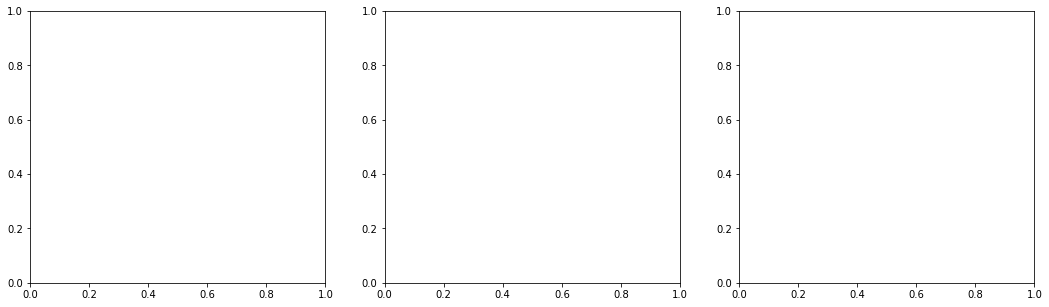

In [18]:
# STEP 11: VISUALIZATIONS
print("\n" + "="*70)
print("STEP 11: VISUALIZATIONS")
print("="*70)

# Plot 1: Model Performance Comparison (R², RMSE, MAE)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Comparison
metrics_pivot = metrics_df.pivot(index='item', columns='model', values='test_r2')
metrics_pivot.plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Test R² Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('R² Score')
axes[0].legend(title='Model')
axes[0].tick_params(axis='x', rotation=45)

# RMSE Comparison
metrics_pivot = metrics_df.pivot(index='item', columns='model', values='rmse')
metrics_pivot.plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('RMSE (units)')
axes[1].legend(title='Model')
axes[1].tick_params(axis='x', rotation=45)

# MAE Comparison
metrics_pivot = metrics_df.pivot(index='item', columns='model', values='mae')
metrics_pivot.plot(kind='bar', ax=axes[2], color=['#1f77b4', '#ff7f0e'])
axes[2].set_title('MAE Comparison (Confidence Interval)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAE (units)')
axes[2].legend(title='Model')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join('output', 'plots', 'model_comparison.png'), dpi=100, bbox_inches='tight')
plt.show()
print("✓ Saved model_comparison.png")

# Plot 2: Actual vs Predicted (for each model)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for idx, item in enumerate(categories):
    # XGBoost
    xgb_data = all_preds_df[(all_preds_df['item'] == item) & (all_preds_df['model'] == 'XGBoost')]
    if not xgb_data.empty:
        axes[idx].scatter(xgb_data['actual'], xgb_data['predicted'], alpha=0.6, label='XGBoost', s=50)
    
    # LSTM
    lstm_data = all_preds_df[(all_preds_df['item'] == item) & (all_preds_df['model'] == 'LSTM')]
    if not lstm_data.empty:
        axes[idx].scatter(lstm_data['actual'], lstm_data['predicted'], alpha=0.6, label='LSTM', s=50)
    
    # y=x line
    data_combined = pd.concat([xgb_data, lstm_data])
    if not data_combined.empty:
        mins = min(data_combined['actual'].min(), data_combined['predicted'].min())
        maxs = max(data_combined['actual'].max(), data_combined['predicted'].max())
        axes[idx].plot([mins, maxs], [mins, maxs], 'r--', alpha=0.5, linewidth=2)
        axes[idx].set_xlim(mins - 5, maxs + 5)
        axes[idx].set_ylim(mins - 5, maxs + 5)
    
    axes[idx].set_title(item, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join('output', 'plots', 'actual_vs_predicted.png'), dpi=100, bbox_inches='tight')
plt.show()
print("✓ Saved actual_vs_predicted.png")

# Plot 3: Metrics Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
metrics_pivot = metrics_df.pivot(index='item', columns='model', values='test_r2')
sns.heatmap(metrics_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, cbar_kws={'label': 'R² Score'})
ax.set_title('Model Performance Heatmap (R² Scores)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join('output', 'plots', 'performance_heatmap.png'), dpi=100, bbox_inches='tight')
plt.show()
print("✓ Saved performance_heatmap.png")

print("\n" + "="*70)
print("VISUALIZATION SUMMARY")
print("="*70)
print("✓ model_comparison.png — R², RMSE, MAE by item and model")
print("✓ actual_vs_predicted.png — Scatter plots for all items")
print("✓ performance_heatmap.png — R² scores heatmap")
